In [2]:
import numpy as np
import matplotlib.pyplot as plt
t_w=100
import os
import chaospy as cp
from FHNCUDAlib import FHNCUDA

nc=12

def plota(data,T):
    print(np.shape(data))
    # Create a meshgrid for X and Y values
    x = np.linspace(0, 50, np.shape(data)[1])
    y = np.linspace(0, 12, np.shape(data)[0])
    X, Y = np.meshgrid(x, y)

    # Create a figure and 3D Axes objects for subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': '3d'})

    # Plot the surface color plots on each subplot
    surfs = []
    data_arrays = [data, data]
    plot_titles = ['Data', 'Data']
    mi,ma=0,1
    #print(data)
    for i, ax in enumerate(axs):
        if(i==2):
            ax.set_zlim(0,0.1) 
            mi,ma=0,0.1
        
        surf = ax.plot_surface(X, Y, data, cmap='viridis',vmin=mi,vmax=ma)
        surfs.append(surf)
        ax.set_title(plot_titles[i])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Value')
        fig.colorbar(surf, ax=ax)
        if(i==2):
            ax.set_zlim(0,0.6) 
    # Show the multi-plot
    plt.tight_layout()
    plt.show()

def generateExactSolution(t,dt,x0,w0,rate,P,begin,end):
    
    
    n2=int(t/(dt))+2
    n = int((end-begin)/(dt*rate))
    Sol=np.zeros((n,3))
  
    Sol2=np.zeros((n2,2))
    Sol2[0]=x0,w0
    T=0
    k=0
    while(k<n2-1):
        x,w=Sol2[k]
        Sol2[k+1]=10*(x*(x-0.4)*(1-x)-w + P)*dt+  x, 0.2*(x*0.2-0.8*w)*dt +w
 
        if ((k*dt==begin or ((k+1)%rate == 0 and k*dt>=begin and k*dt<=end))and T<n):
          
           
            Sol[T] = Sol2[k][0],Sol2[k][1] , k*dt
            T=T+1
        
        k=k+1
        if(k*dt > end):
            break
    return Sol
def unique(array):
        uniq, index = np.unique(array, return_index=True)
        return uniq[index.argsort()]
def getDatasetFromDistA(sample_set, data_folder="./extrapol/",ti=0,tf=50,r=1,deltaT=0.01):
    try:
        os.mkdir(data_folder)
    except:
        print("overweriting")
    T = np.empty(0)
    K = np.empty(0)

    V = np.empty(0)
    U = np.empty(0)
    print("Generating dataset in",data_folder)



    rate =10*r
    num_samples= np.shape((sample_set))[1]
    # Generate Latin Hypercube Samples
    print(np.shape(sample_set))
    u,v ,t,p=FHNCUDA.run(sample_set.T,tf,deltaT,rate)
    SOLs=np.array(u).flatten()
    SOLw=np.array(v).flatten()
    t=t[0]
    T =np.tile(t,num_samples)

    
    K= np.repeat(unique(sample_set[2,:]),len(t))
    
  
    U =np.repeat(unique(sample_set[0,:]),len(t))
    V =np.repeat(unique(sample_set[1,:]),len(t))
    
    n=len(t)
    

    # Remove every nth element starting from the second element
    SOLs = SOLs[np.arange(len(SOLs)) % n != 0]
    SOLw = SOLw[np.arange(len(SOLw)) % n != 0]
    T = T[np.arange(len(T)) % n != 0]
    K = K[np.arange(len(K)) % n != 0]
    U = U[np.arange(len(U)) % n != 0]
    V = V[np.arange(len(V)) % n != 0]



    print("Generated_set")
    print(SOLs[:10])
    plt.plot(SOLs[0:5*int((tf-ti)//(deltaT*rate))])
    plt.show()
    # Save data arrays to CSV files
    np.save(data_folder + "T.npy", T)
    np.save(data_folder + "K.npy", K)
    np.save(data_folder + "U.npy", U)
    np.save(data_folder + "V.npy", V)
    np.save(data_folder + "SOLs.npy", SOLs)
    np.save(data_folder + "SOLw.npy", SOLw)
    nc=num_samples
    pred_u= np.reshape(SOLs, (nc,len(t)-1))
    true_u= np.reshape(SOLs, (nc,len(t)-1))
    plota(pred_u,T)
    



C:\Users\yanbw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0.09746543 0.01312208 0.10830693]
Gerando treino 
overweriting
Generating dataset in ../training_data/treino/
(3, 49500)
kernel call: ./a.out 20 0.01 10
239
Number of rows in the CSV file:  49500 202
Generated_set
[ 0.351369  0.315354  0.270431  0.21752   0.159999  0.103723  0.055092
  0.018087 -0.007056 -0.022651]


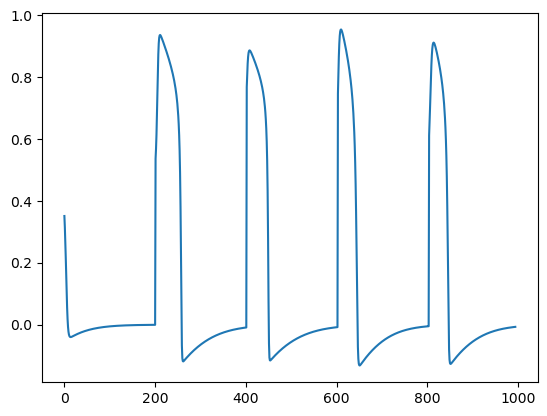

(49500, 201)


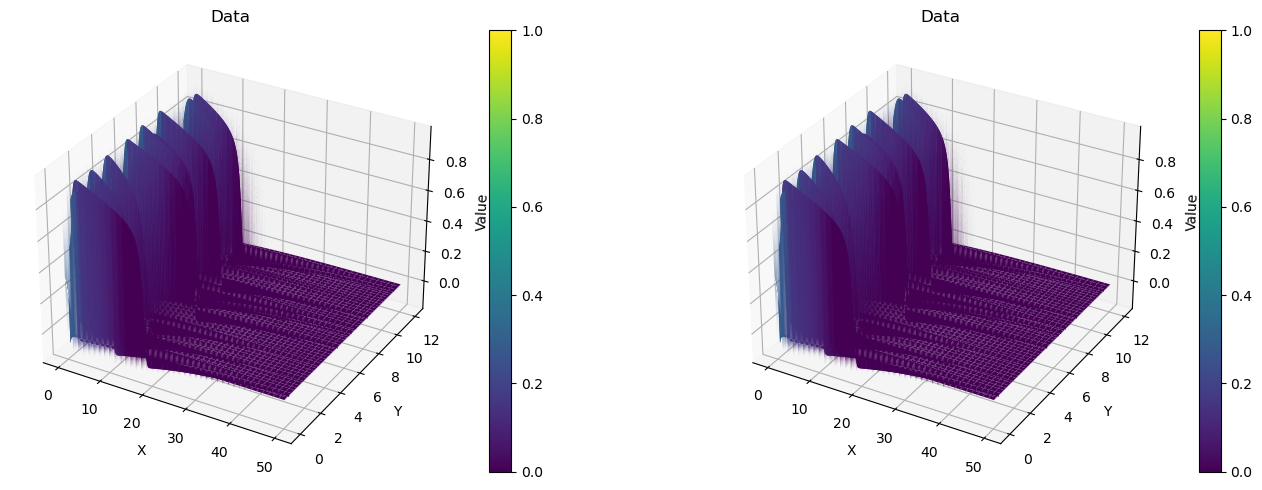

Gerando validaçao
overweriting
Generating dataset in ../training_data/validation/
(3, 500)
kernel call: ./a.out 20 0.01 10
236
Number of rows in the CSV file:  500 202
Generated_set
[ 0.097465  0.058511  0.028699  0.007881 -0.005632 -0.013919 -0.018757
 -0.021434 -0.022797 -0.023377]


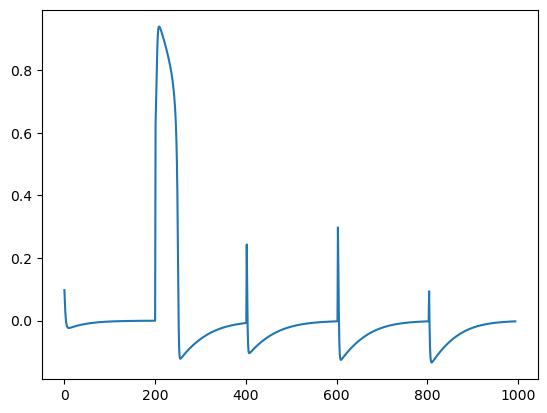

(500, 201)


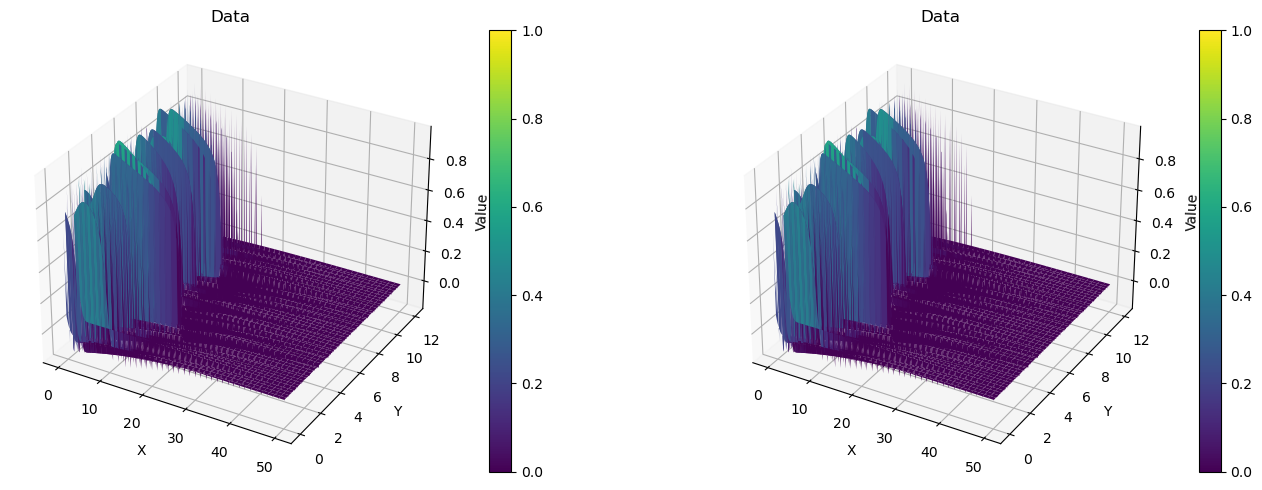

In [8]:
# Define the ranges
krange = [0., 1]
vrange = [0.0, 0.12]
urange = [-.1, 0.81]
    # Create uniform distributions
k_dist = cp.Uniform(*krange)
v_dist = cp.Uniform(*vrange)
u_dist = cp.Uniform(*urange)

    
joint_dist = cp.J(u_dist,v_dist,k_dist)
T=5E4
sample_set = joint_dist.sample(T, rule="L").T
np.random.shuffle(sample_set)


sample_set=sample_set.T



print(sample_set.T[0])



print("Gerando treino ")
getDatasetFromDistA(sample_set[:,int(T*0.01):],data_folder="../training_data/treino/",ti=0,tf=20)
print("Gerando validaçao")
getDatasetFromDistA(sample_set[:,0:int(T*0.01)],data_folder="../training_data/validation/",ti=0,tf=20)

[0.76096507 0.02471752 0.54811207]
Gerando monitores 
overweriting
Generating dataset in ./training_data/monitor/
(3, 500)
kernel call: ./a.out 200 0.01 100
238
Number of rows in the CSV file:  500 201
Generated_set
[ 0.934464  0.887211  0.83036   0.740898  0.194623 -0.113411 -0.096845
 -0.082156 -0.069243 -0.057989]


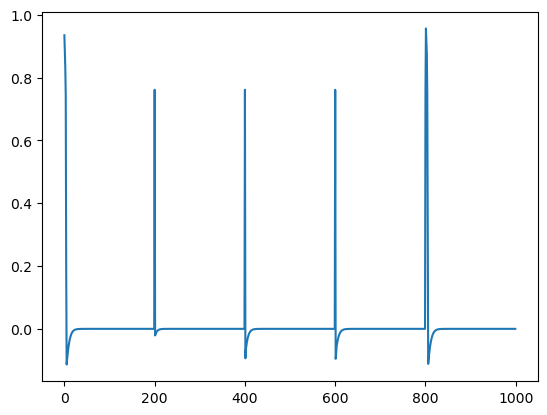

FileNotFoundError: [Errno 2] No such file or directory: './training_data/monitor/T.npy'

In [4]:
# Define the ranges
krange = [0., 1]
vrange = [0., 0.12]
urange = [-.1, 0.81]
    # Create uniform distributions
k_dist = cp.Uniform(*krange)
v_dist = cp.Uniform(*vrange)
u_dist = cp.Uniform(*urange)

    
joint_dist = cp.J(u_dist,v_dist,k_dist)
T=5E2
sample_set = joint_dist.sample(T, rule="L").T
np.random.shuffle(sample_set)


sample_set=sample_set.T



print(sample_set.T[0])



print("Gerando monitores ")
getDatasetFromDistA(sample_set,data_folder="./training_data/monitor/",ti=0,tf=200,r=10)

x_values = []
y_values = []
z_values = []

with open("data.txt", "r") as file:
    # Read each line in the file
    for line in file:
        #print(line)
        # Split the line into individual values
        values = line.strip().split(",")
        # Extract and convert the values to appropriate data types
        x_values.append(float(values[0]))
        y_values.append(float(values[1]))
        z_values.append(float(values[2]))

        

sample_set = np.stack((x_values, y_values, z_values), axis=0)
print(np.shape(sample_set))

sample_set=np.tile(sample_set, ( 1, int(2e2)))
print(np.shape(sample_set))
epsilon = 0.001  # Perturbation magnitude
perturbation = np.random.uniform(-epsilon, epsilon, sample_set.shape)
sample_set = sample_set + perturbation

print("Gerando treino region")
##Lista
getDatasetFromDistA(sample_set,data_folder="./training_data/treinocr/",ti=0,tf=200,r=5,deltaT=0.01)



Val Error


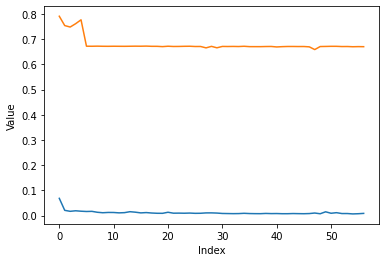

Last Validation Set


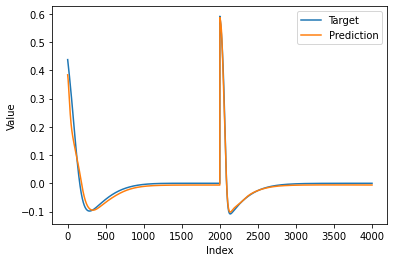

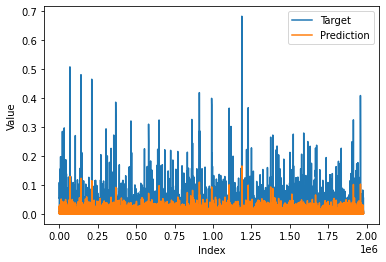

1187323


In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
def plot_results(file_path):
    with h5py.File(file_path+"val.h5", 'r') as hf:
        target = hf['target'][:]
        pred = hf['pred'][:]
            
    with h5py.File(file_path+"val_err.h5", 'r') as hf:
        err = hf['error_stats'][:]

    print("Val Error")
    plt.plot(err)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()
    print("Last Validation Set")
    plt.plot(target[:4000, 0])
    plt.plot(pred[:4000, 0])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend(['Target', 'Prediction'])
    plt.show()

    absolute_error =np.abs(target - pred)
    plt.plot(absolute_error)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend(['Target', 'Prediction'])
    plt.show()
    
   

# Find index of maximum error
    max_error_index = np.argmax(absolute_error.T[0])
    print(max_error_index)
    window_size = 2000

    # Plot target and prediction around the region of maximum error
    start_index = max(0, max_error_index - window_size)
    end_index = min(len(target), max_error_index + window_size)

    plt.plot(target[start_index:end_index, 0], label='Target')
    plt.plot(pred[start_index:end_index, 0], label='Prediction')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    
    plt.scatter(target[:4000, 0], pred[:4000, 0])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend(['Target', 'Prediction'])
    plt.show()

# Call the plot_results function with the path to your HDF5 file
file_path = "trainer/"
plot_results(file_path)

Val Error


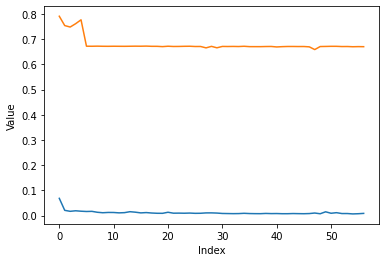

Last Validation Set


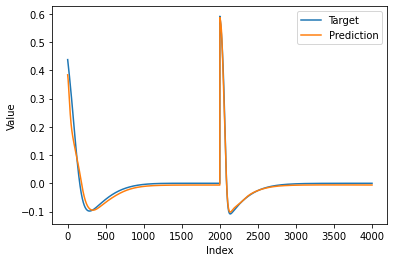

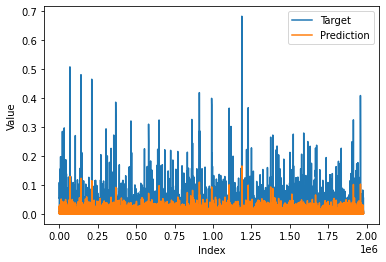

1187323


In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
def plot_results(file_path):
    with h5py.File(file_path+"val.h5", 'r') as hf:
        target = hf['target'][:]
        pred = hf['pred'][:]
            
    with h5py.File(file_path+"val_err.h5", 'r') as hf:
        err = hf['error_stats'][:]

    print("Val Error")
    plt.plot(err)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()
    print("Last Validation Set")
    plt.plot(target[:4000, 0])
    plt.plot(pred[:4000, 0])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend(['Target', 'Prediction'])
    plt.show()

    absolute_error =np.abs(target - pred)
    plt.plot(absolute_error)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend(['Target', 'Prediction'])
    plt.show()
    
   

# Find index of maximum error
    max_error_index = np.argmax(absolute_error.T[0])
    print(max_error_index)
    window_size = 2000

    # Plot target and prediction around the region of maximum error
    start_index = max(0, max_error_index - window_size)
    end_index = min(len(target), max_error_index + window_size)

    plt.plot(target[start_index:end_index, 0], label='Target')
    plt.plot(pred[start_index:end_index, 0], label='Prediction')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    
    plt.scatter(target[:4000, 0], pred[:4000, 0])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend(['Target', 'Prediction'])
    plt.show()

# Call the plot_results function with the path to your HDF5 file
file_path = "trainer/"
plot_results(file_path)

In [3]:
import torch

ModuleNotFoundError: No module named 'torch'